In [1]:
!pip install scipy

In [2]:
%pip install --extra-index-url https://artefact.skao.int/repository/pypi-internal/simple \
  git+https://gitlab.com/ska-telescope/ska-low-csp-test  # for visibility unpacking and plotting

Looking in indexes: https://pypi.org/simple, https://artefact.skao.int/repository/pypi-internal/simple
  Cloning https://gitlab.com/ska-telescope/ska-low-csp-test to /tmp/pip-req-build-z5r1b9c9
  Running command git clone --filter=blob:none --quiet https://gitlab.com/ska-telescope/ska-low-csp-test /tmp/pip-req-build-z5r1b9c9
  Resolved https://gitlab.com/ska-telescope/ska-low-csp-test to commit 57ba969e6091cce73aad8eedaf8c437a5a53529b
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [3]:
from ska_low_csp_test.cbf import visibilities
from ska_low_csp_test.domain import plotting
from ska_low_csp_test.cbf.visibilities import Polarization
from PIL import Image
from matplotlib import pyplot as plt
from io import BytesIO

import scipy

## Read data file

In [4]:
filename = "/mnt/clp-k8s-fpga-worker-1/pcap/output/config-2024-07-01T10-09-46.180655_scan-1.pcap"
filename = "/mnt/clp-k8s-fpga-worker-1/pcap/output/config-2024-07-05T09-06-54.290324_scan-1.pcap"
print(filename)

/mnt/clp-k8s-fpga-worker-1/pcap/output/config-2024-07-05T09-06-54.290324_scan-1.pcap


In [5]:
pcap_output = visibilities.unpack_pcap_file(filename)

In [6]:
pcap_output.metadata

ScaID  Chann  Epoch  ZoomI  Resol SrcID  BeaID  Subar  Firmw  Basel  \
0          1      0      0      0     32  b'L'      1      1   1792     10   
1          1      1      0      0     32  b'L'      1      1   1792     10   
2          1      2      0      0     32  b'L'      1      1   1792     10   
3          1      3      0      0     32  b'L'      1      1   1792     10   
4          1      4      0      0     32  b'L'      1      1   1792     10   
...      ...    ...    ...    ...    ...   ...    ...    ...    ...    ...   
13819      1  13819      0      0     32  b'L'      1      1   1792     10   
13820      1  13820      0      0     32  b'L'      1      1   1792     10   
13821      1  13821      0      0     32  b'L'      1      1   1792     10   
13822      1  13822      0      0     32  b'L'      1      1   1792     10   
13823      1  13823      0      0     32  b'L'      1      1   1792     10   

           Hardw     Integ        Frequ      FreHz  
0      890204496  0.849347  5425.347168  162111975  
1      890204496  0.849347  5425.347168  162117400  
2      890204496  0.849347  5425.347168  162122825  
3      890204496  0.849347  5425.347168  162128251  
4      890204496  0.849347  5425.347168  162133676  
...          ...       ...          ...        ...  
13819  890204496  0.849347  5425.347168  237084848  
13820  890204496  0.849347  5425.347168  237090273  
13821  890204496  0.849347  5425.347168  237095699  
13822  890204496  0.849347  5425.347168  237101124  
13823  890204496  0.849347  5425.347168  237106549  

[13824 rows x 14 columns]

In [7]:
pcap_output.data

<xarray.Dataset> Size: 13MB
Dimensions:             (channel_id: 13824, baseline: 10, polarization: 4,
                         epoch_offset: 3)
Coordinates:
  * channel_id          (channel_id) int64 111kB 0 1 2 3 ... 13821 13822 13823
  * baseline            (baseline) <U6 240B '(0, 0)' '(1, 0)' ... '(3, 3)'
  * polarization        (polarization) <U2 32B 'XX' 'XY' 'YX' 'YY'
  * epoch_offset        (epoch_offset) uint64 24B 773485691580333000 ... 7734...
    scan_id             (epoch_offset) uint64 24B 1 1 1
Data variables:
    773485691580333000  (channel_id, baseline, polarization) complex64 4MB (9...
    773485692429679560  (channel_id, baseline, polarization) complex64 4MB (9...
    773485693279026120  (channel_id, baseline, polarization) complex64 4MB (9...
Attributes:
    baselines_auto_idx:   [0, 2, 5, 9]
    baselines_cross_idx:  [1, 3, 4, 6, 7, 8]

## Unpack the data

In [8]:
VIS = pcap_output.data.to_array(dim="epoch_offset")

auto_corr_bls = VIS.baselines_auto_idx
cross_corr_bls = VIS.baselines_cross_idx

In [9]:
import xarray as xr
import numpy as np
from datetime import datetime, timezone
import matplotlib.pylab as plt

In [10]:
# how many scan ids
scan_ids = np.unique(VIS.scan_id.data)
# get epoch offset
epoch_offset = VIS.epoch_offset.data / 1e9
# channels
channels = VIS.channel_id.data

In [11]:
[n_ts, n_chan, n_bl, n_corr] = VIS.shape
n_stations = int((-1 + np.sqrt(1+8*n_bl))/2)
station_ids = [345, 350, 352, 431]
if n_stations != len(station_ids):
    raise RuntimeError("Single baseline test {station_ids} has baselines for {n_stations}")
# assuming baseline order as per perentie notebooks
bls = np.arange((n_stations*(n_stations+1))//2)
bl_lookup = np.empty([len(bls), 2], dtype="i4")
bl_idx=0
for A in range(0, n_stations):
    for B in range(0, A+1):
        bl_lookup[bl_idx] = [station_ids[A], station_ids[B]]
        bl_idx +=1

print(bl_lookup)

[[345 345]
 [350 345]
 [350 350]
 [352 345]
 [352 350]
 [352 352]
 [431 345]
 [431 350]
 [431 352]
 [431 431]]


## Plotting utility functions


In [19]:
def fit_trend(xvalues, yvalues):
    # Fit the trend line.
    (m, b), (SSE,), *_ = np.polyfit(xvalues, yvalues, deg=1, full=True)
    return m, b

def subplot_(hndl, xvalues, yvalues, corr_, label_, set_xticks=False, show_stats_lines=False):
    amplitude = np.abs(yvalues)
    phase = np.angle(yvalues)
    
    if len(xvalues) < 20:
        xticks_vals = xvalues
    else:
        step = int(len(xvalues)/20)
        xticks_vals = xvalues[::step]
    
    if show_stats_lines:
        hndl[0].axhline(y=np.mean(amplitude), color='y', linestyle=":")
        hndl[0].axhline(y=np.mean(amplitude)+np.std(amplitude), color='y', linestyle="--")
        hndl[0].axhline(y=np.mean(amplitude)-np.std(amplitude), color='y', linestyle="--")
    m, b = fit_trend(xvalues, amplitude)
    line = m * xvalues + b
    hndl[0].plot(xvalues, amplitude, ".--", xvalues, line, 'k:')
    hndl[0].set_ylabel(f'{corr_} Amplitude [arb]')
    hndl[0].set_xticks(xticks_vals)
    hndl[0].set_xticklabels(hndl[0].get_xticklabels(), rotation=45) 
    
##    flat = (np.max(line) - (np.mean(amplitude)+np.std(amplitude)) < 0)
#    params = scipy.stats.skewnorm.fit(amplitude)    
#    a, loc, scale = params
#    flat = (np.abs(a) < 3)

#    clr = 'green' if flat else 'red'
#    hndl[0].annotate(f'Line is flat [{flat}]',
#            xy=(0, 1), xycoords='axes fraction',
#            xytext=(0, 0), textcoords='offset pixels',
#            horizontalalignment='left',
#            verticalalignment='top',
#            color=clr, fontsize=14)

    if show_stats_lines:    
        hndl[1].axhline(y=np.mean(phase), color='y', linestyle=":")
        hndl[1].axhline(y=np.mean(phase)+np.std(phase), color='y', linestyle="--")
        hndl[1].axhline(y=np.mean(phase)-np.std(phase), color='y', linestyle="--")
    m, b = fit_trend(xvalues, phase)
    line = m * xvalues + b
    hndl[1].plot(xvalues, phase, "*-", xvalues, line, 'k:', label=label_)
    hndl[1].set_ylabel(f'{corr_} Phase [arb]')
    hndl[1].set_ylim([-np.pi, np.pi])
    hndl[1].set_xticks(xticks_vals)
    hndl[1].set_xticklabels(hndl[1].get_xticklabels(), rotation=45)        
    flat = (np.abs(np.max(phase)-np.min(phase)) < 0.001)
    clr = 'green' if flat else 'red'
    hndl[1].annotate(f'Line is flat [{flat}]',
            xy=(0, 1), xycoords='axes fraction',
            xytext=(0, 0), textcoords='offset pixels',
            horizontalalignment='left',
            verticalalignment='top',
            color=clr, fontsize=14)
    hndl[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def get_scan(VIS, scan_id):
    return VIS[VIS.scan_id == scan_id]
def get_scan_mask(VIS, scan_id):
    return [VIS.scan_id == scan_id][0].data

## Inspect the data


In [20]:
# for plots over time, normalise all timestamps to be the number of milliseconds from start of scan
timestamps = (epoch_offset-epoch_offset[0])*1e3

print(f"Total execution run {(timestamps[-1]-timestamps[0])/1e3} seconds")
for scan_id in scan_ids:
    scan_epoch_mask = get_scan_mask(VIS, scan_id)
    ts = timestamps[scan_epoch_mask]
    print(f" Scan {scan_id} execution time {(ts[-1]-ts[0])/1e3} seconds")

Total execution run 1.698693037033081 seconds
 Scan 1 execution time 1.698693037033081 seconds


### Autocorrelation amp and phase over time

In [21]:
def plot_over_time(ts, data, scan_id, bls, bl_lookup, overplot=False):
    [n_ts, n_bls, n_corrs] = data.shape
    if overplot:
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 12))
        show_stats_lines=False
    for bl_idx in bls:
        if not overplot:
            fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 12))
            show_stats_lines=True
        label=f"bl {bl_idx} {bl_lookup[bl_idx]}"
        plt_cnt = 0
        for ax_idx, corr_ in enumerate(["XX","YY"]):
            if corr_ == "XY" or corr_ == "YX": continue
            subplot_(axes[plt_cnt], ts, data[:,bl_idx,ax_idx], corr_, label, show_stats_lines=show_stats_lines)
            axes[plt_cnt][0].set_xlabel("Time (ms) since start")
            axes[plt_cnt][1].set_xlabel("Time (ms) since start")
            plt_cnt += 1

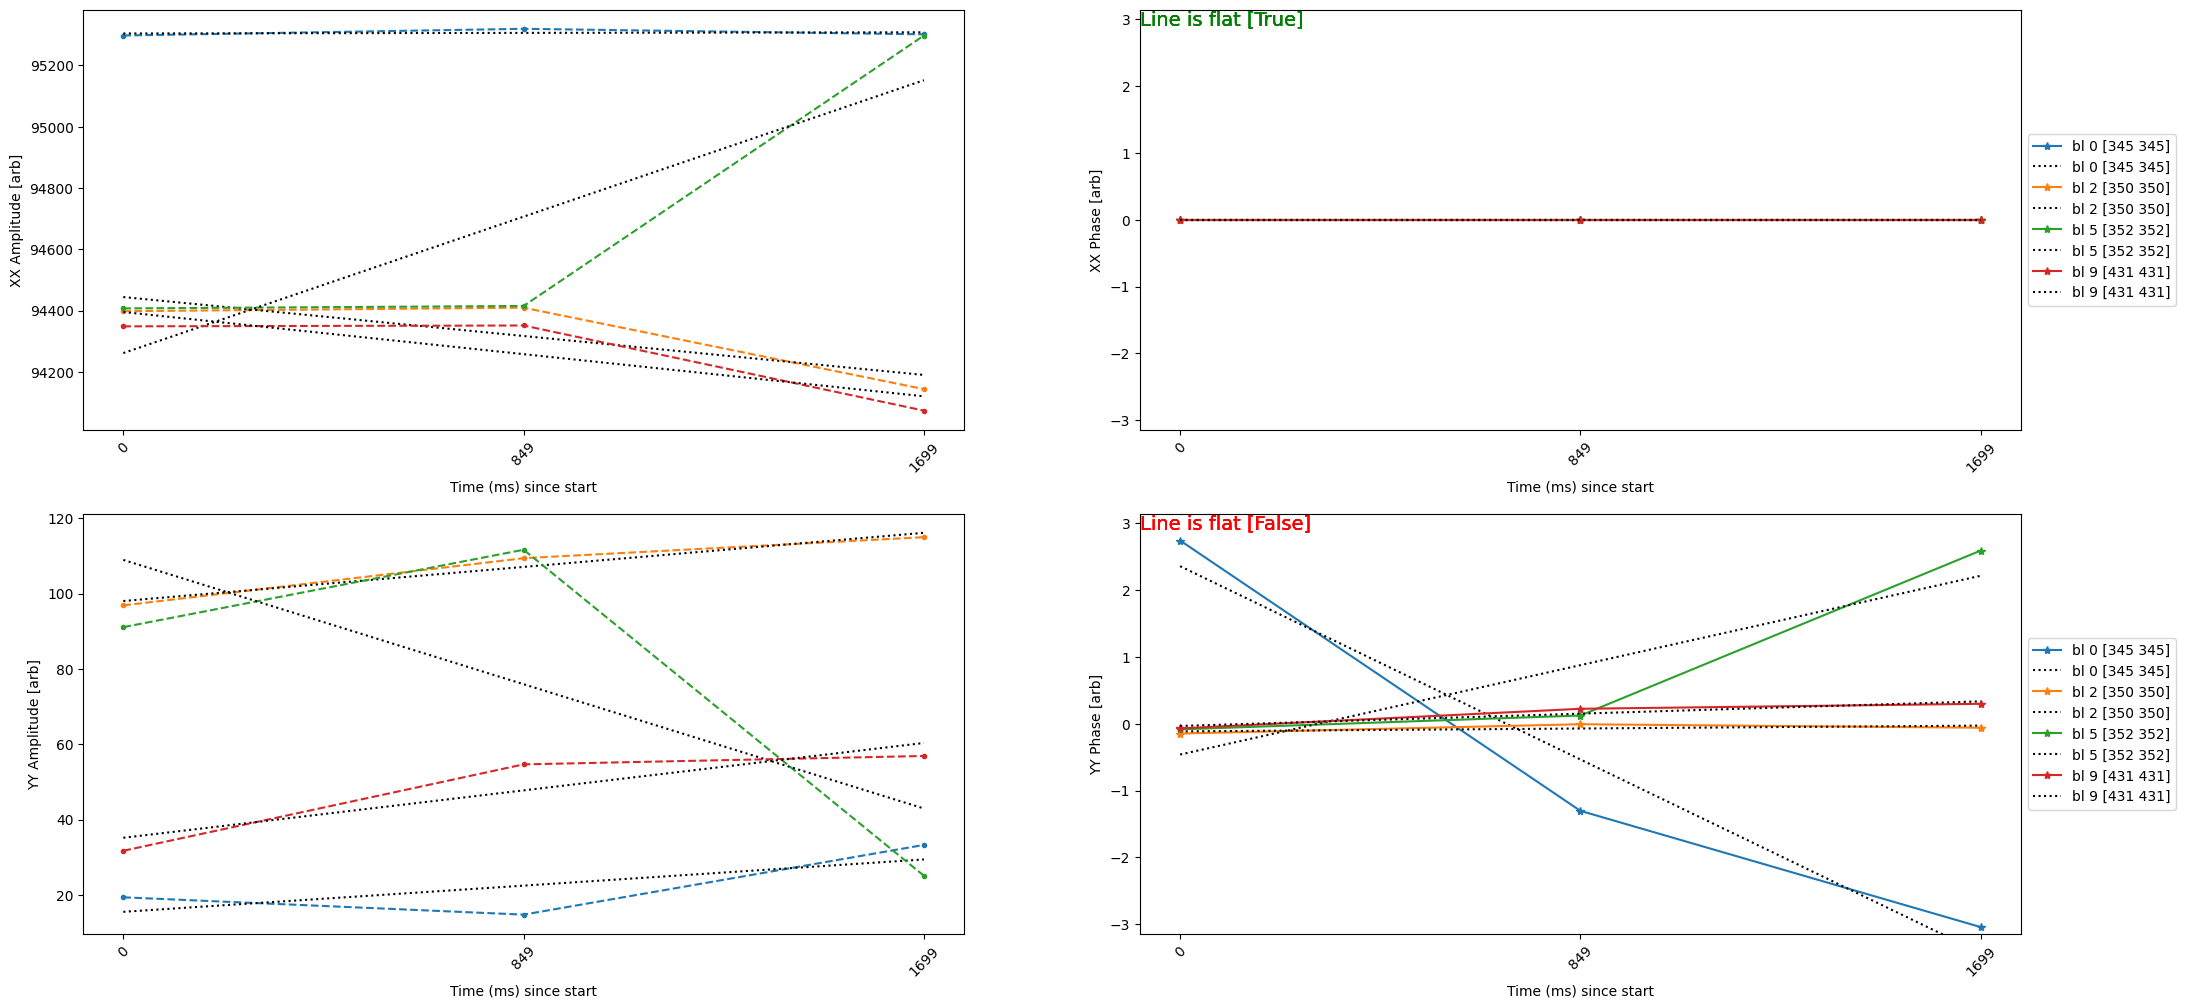

In [22]:
for scan_id in scan_ids:
    scan_samples = get_scan(VIS, scan_id)
    scan_epoch_mask = get_scan_mask(VIS, scan_id)
    scan_times = [datetime.fromtimestamp(ts, timezone.utc) for ts in timestamps[scan_epoch_mask]]
    # show over all timestamps
    # plot_over_time(timestamps[scan_epoch_mask], scan_samples.data.mean(axis=1), scan_id, auto_corr_bls, bl_lookup, overplot=True)
    plot_over_time(timestamps[scan_epoch_mask], np.nanmean(scan_samples.data, axis=1), scan_id, auto_corr_bls, bl_lookup, overplot=True)
    
    # ignore timestamps that show outliers
    #plot_over_time(timestamps[scan_epoch_mask][3:], scan_samples.data.mean(axis=1)[3:], scan_id, auto_corr_bls, bl_lookup, overplot=True)

### Autocorrelation amp and phase over channel

SKAO_IF-LOW_CBF_SDP-14
The order of baselines in a SPEAD heap will be defined by a sorted list of stations and substations in ascending order.

Assign stations out of order = 352, 345, 431, and 350
Configure CNIC-VD to generate test signals as described below simulating the output of four LOW stations conforming to the LOW CBF-SPS ICD 
* Simulate the test signal for station 345 to output a tone at 163.28MHz for both XX and YY polarisations of station 345
* Simulate the test signal for station 350 to output a tone at 200MHz for both XX and YY polarisations of station 350
* Simulate the test signal for station 431 to output a tone at 236.719MHz for both XX and YY polarisations of station 431
* Test signals generated for station 352 must all be band-limited pseudo-random noise

In [23]:
# test setup
station_ids = np.array([352, 345, 431, 350])
freq_map = {345:"163.28MHz", 350:"200MHz", 431:"236.719MHz", 352:"None"}

# ascending order
ordered_station_ids = np.sort(station_ids)

# map setup to expected output
bl_layout = np.zeros([len(bls), 4], dtype="i4")
bl_idx=0
for A in range(0, n_stations):
    for B in range(0, A+1):
        bl_layout[bl_idx] = [station_ids[A], station_ids[B], ordered_station_ids[A], ordered_station_ids[B]]
        bl_idx +=1

#print(bl_lookup[auto_corr_bls])
bl_labels = []
for bl_idx in auto_corr_bls:
    label=f"bl {bl_idx} unsorted {bl_layout[bl_idx][:2]} ({freq_map[bl_layout[bl_idx][0]]}) sorted {bl_layout[bl_idx][2:]} ({freq_map[bl_layout[bl_idx][-1]]})"
    clr = "green" if freq_map[bl_layout[bl_idx][0]] == freq_map[bl_lookup[bl_idx][-1]] else "red"
    bl_labels.append([clr, f"bl {bl_idx} unsorted {bl_layout[bl_idx][:2]} ({freq_map[bl_layout[bl_idx][0]]}) sorted {bl_layout[bl_idx][2:]} ({freq_map[bl_lookup[bl_idx][-1]]})"])

In [24]:
def plot_over_channel(chans, data, scan_id, bls, labels):
    [n_chans, n_bls, n_corrs] = data.shape
    for cnt, bl_idx in enumerate(bls):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 15))
        label=f"bl {bl_idx}"
        plt_cnt = 0
        for ax_idx, corr_ in enumerate(["XX","XY","YX","YY"]):
            if corr_ == "XY" or corr_ == "YX": continue
            subplot_(axes[plt_cnt], chans, data[:,bl_idx,ax_idx], corr_, label)
            axes[plt_cnt][0].set_xlabel("Frequency [MHz]")
            axes[plt_cnt][1].set_xlabel("Frequency [MHz]")
            clr = labels[cnt][0]
            msg = labels[cnt][1]
            axes[plt_cnt][0].set_title(msg, color=clr)
            plt_cnt += 1

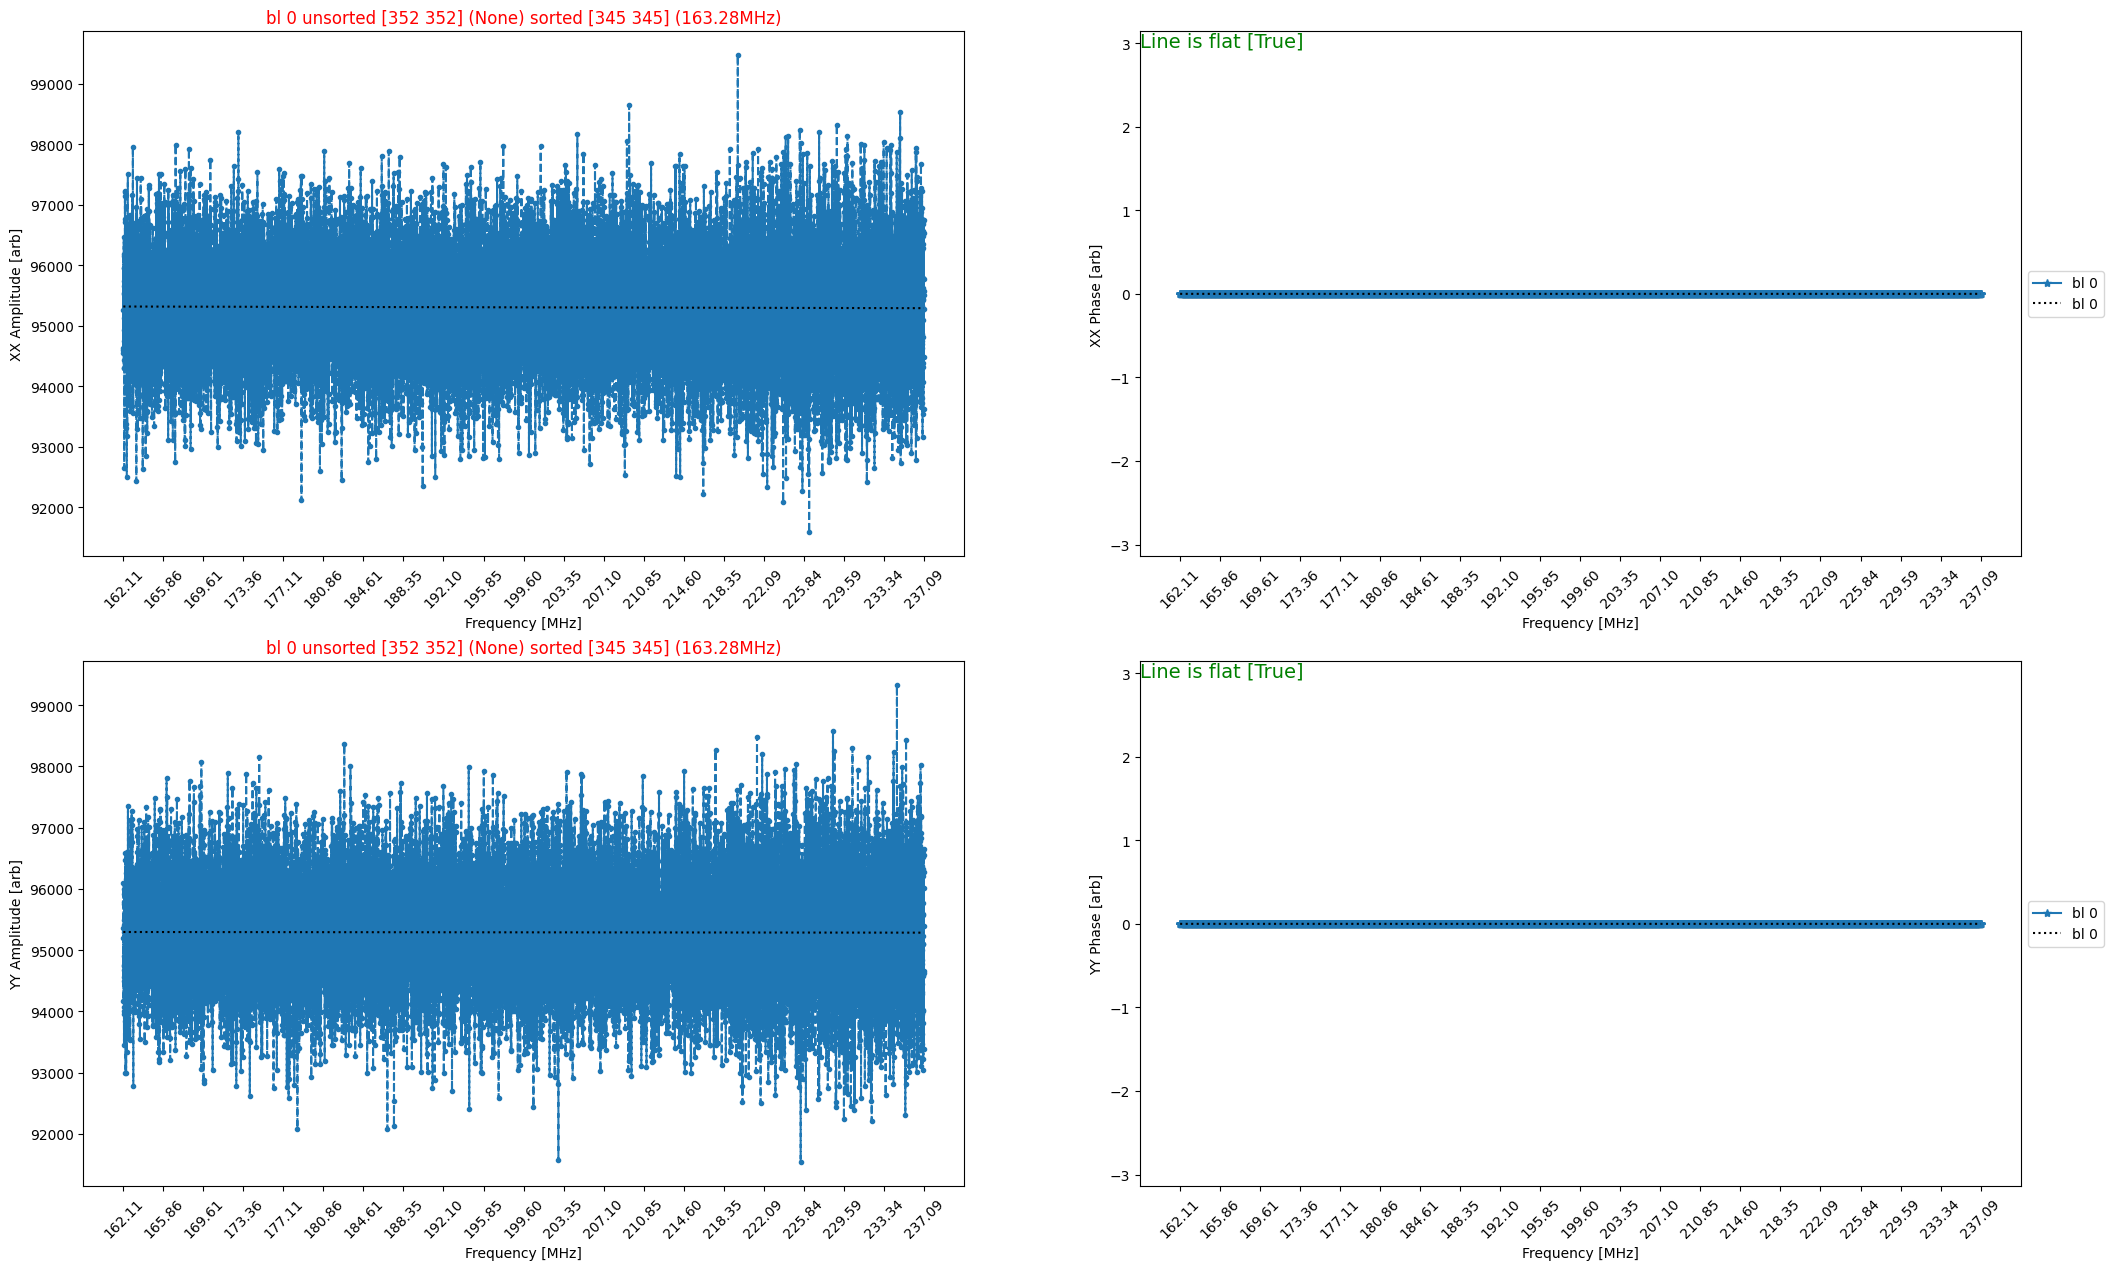

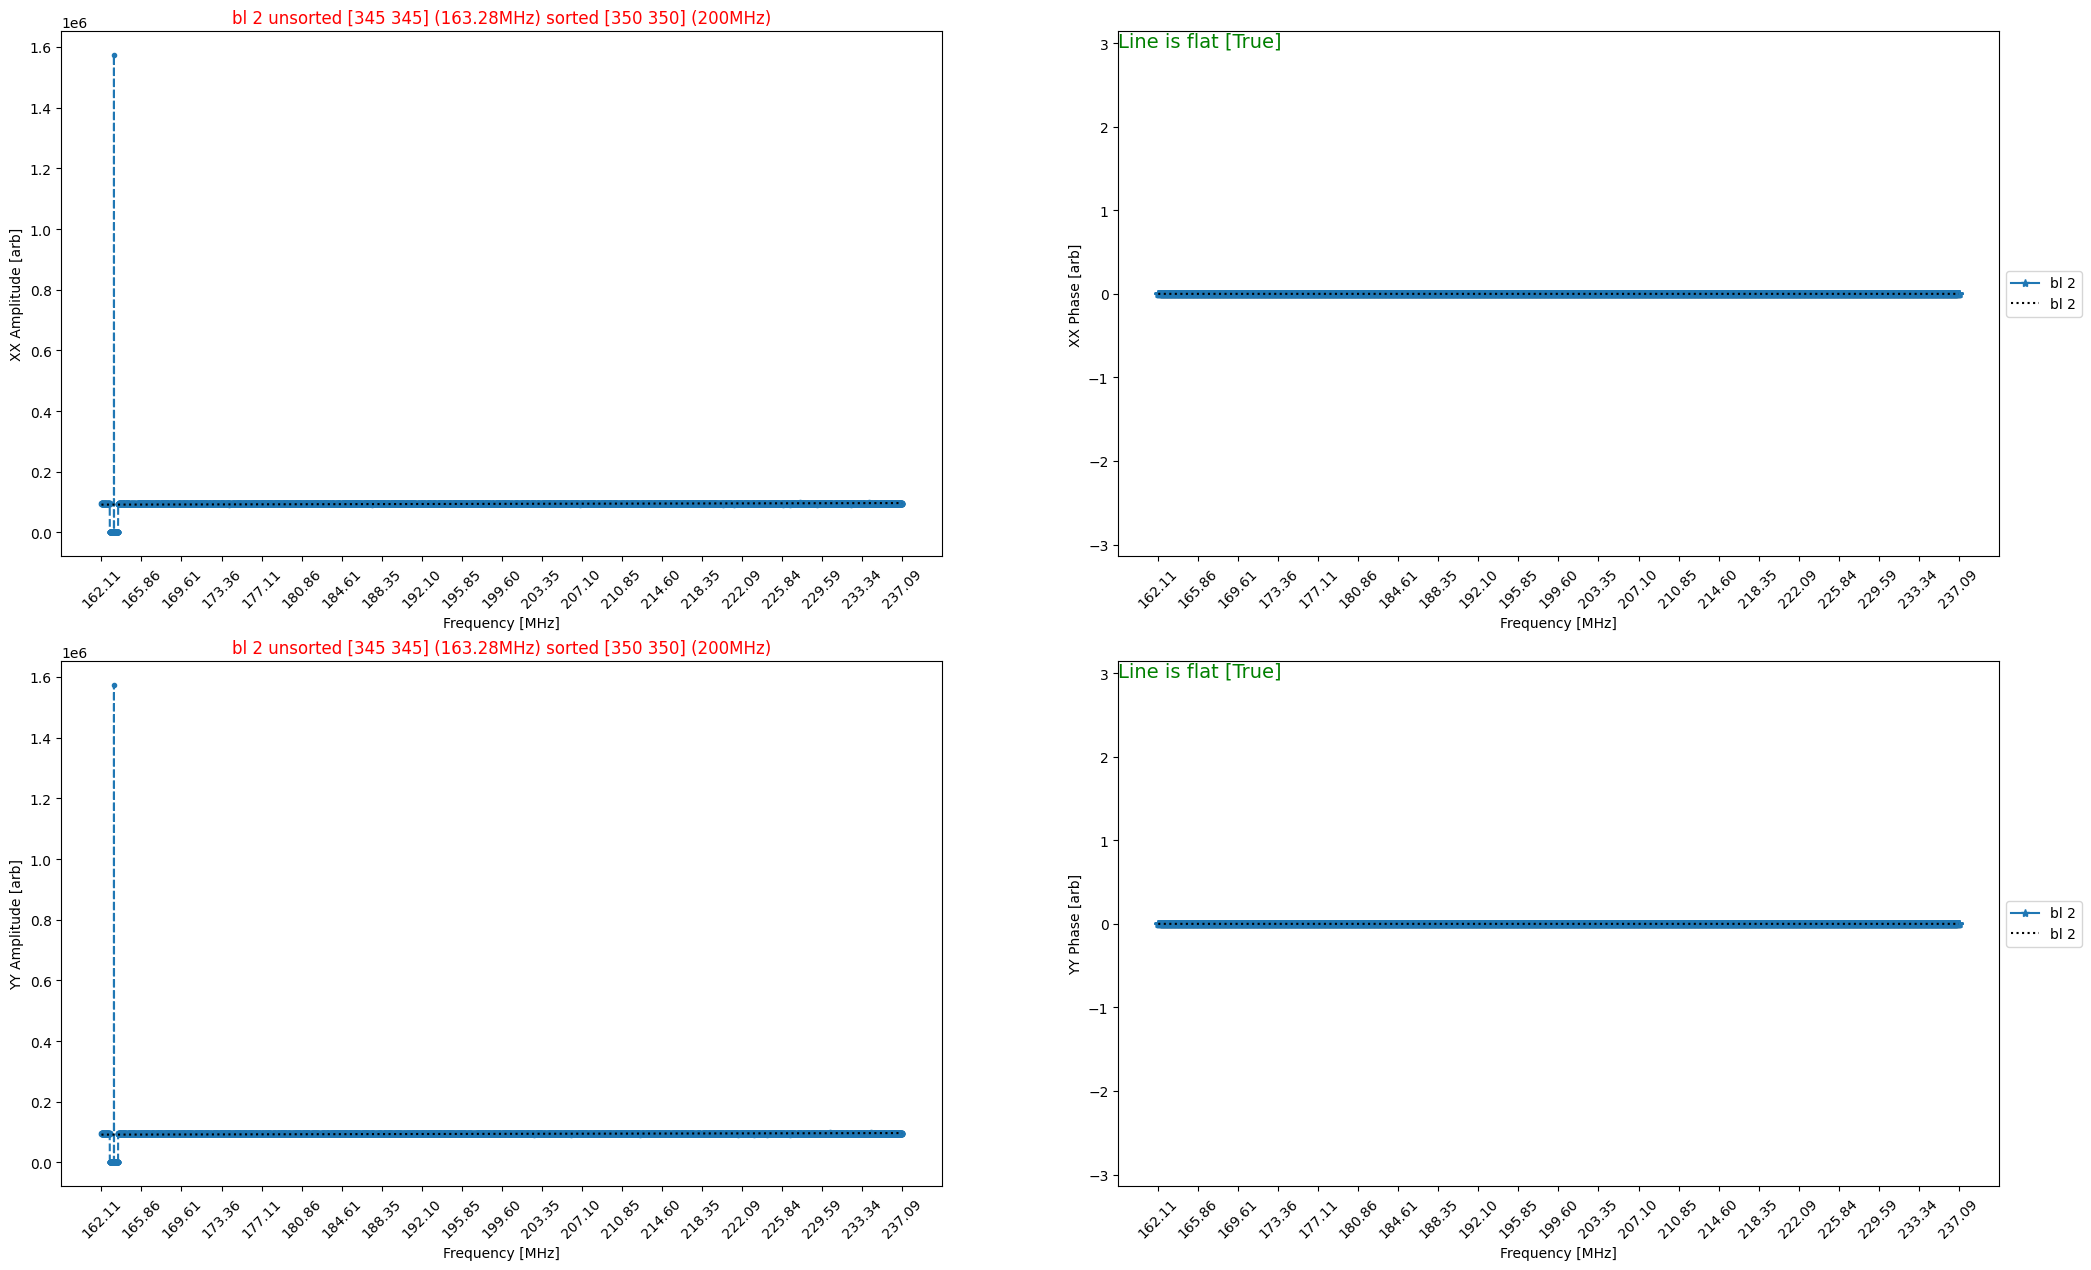

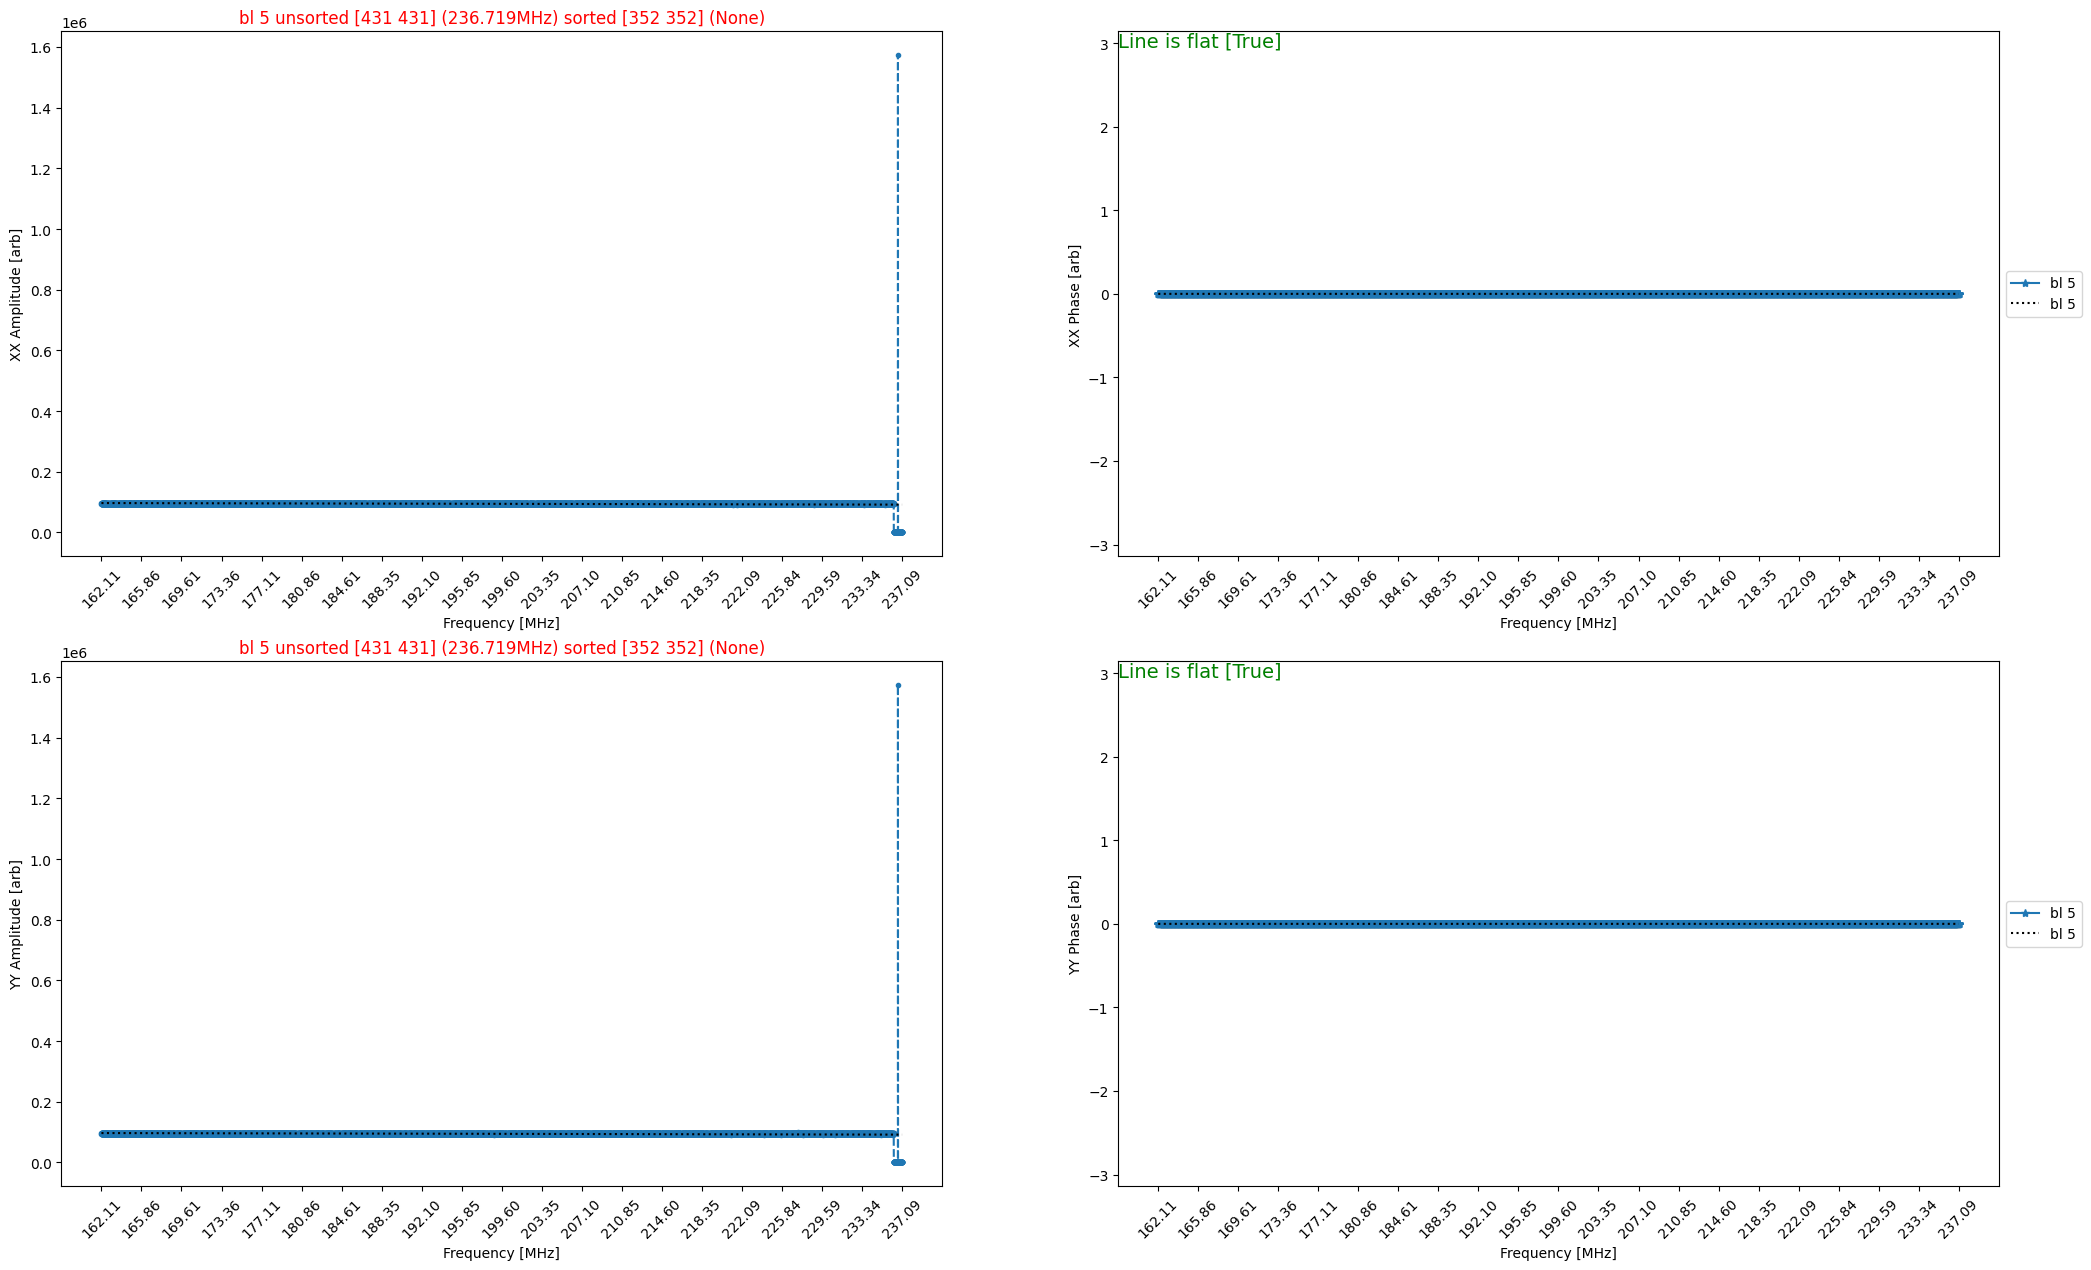

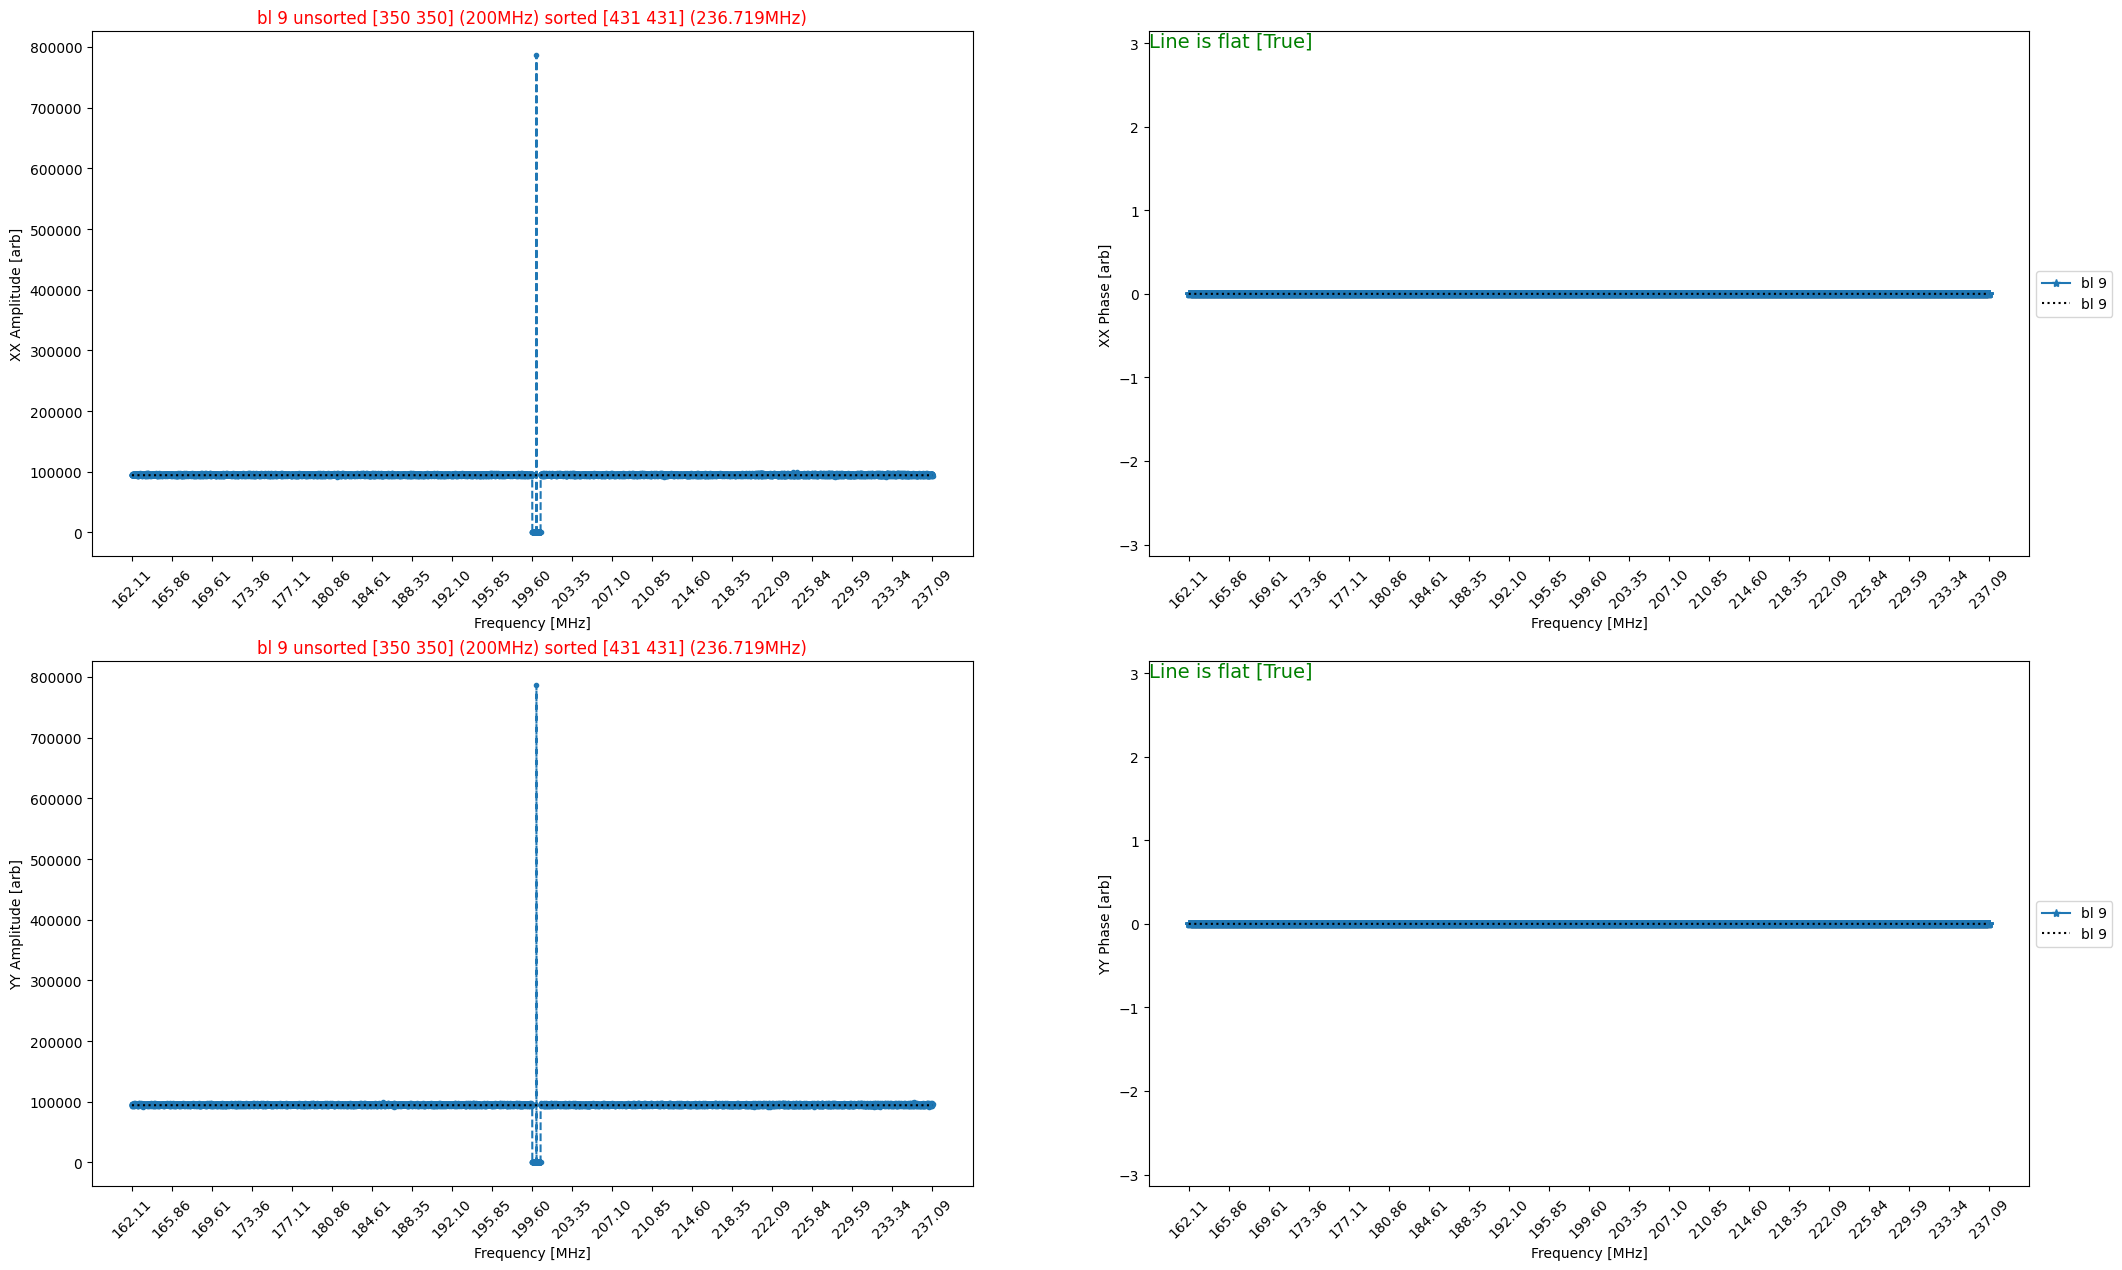

In [25]:
frequencies = pcap_output.metadata.FreHz.values/1e6
for scan_id in scan_ids:
    scan_samples = get_scan(VIS, scan_id)
    # show over all timestamps
    # plot_over_channel(frequencies, scan_samples.data.mean(axis=0), scan_id, auto_corr_bls, bl_labels) 
    plot_over_channel(frequencies, np.nanmean(scan_samples.data, axis=0), scan_id, auto_corr_bls, bl_labels) 